In [9]:
import csv
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy.stats as stats

# Загрузка и подготовка данных

In [10]:
with open("by_repo_results.csv", "r", encoding='utf-8') as f:
  csvreader = csv.reader(f, delimiter=";")
  headers = next(csvreader)
  data = []
  for row in csvreader:
    if row[0].strip(): 
        company_name = row[0]
        company_description = row[1]
        data.append(row)
    else:
        row[0] = company_name
        row[1] = company_description
        data.append(row)

repo_df = pd.DataFrame(data=data, columns=headers).dropna().reset_index().drop('index', axis=1)

org_df = pd.read_csv("by_org_results.csv", delimiter=";").dropna().reset_index().drop('index', axis=1)

In [11]:
repo_df["repo_stars"] = repo_df["repo_stars"].astype(np.int32)
repo_df["repo_half_year_commits"] = repo_df["repo_half_year_commits"].astype(np.int32)

org_df['stars_count'] = org_df['stars_count'].astype(np.int32)

# Гипотезы

### 1. Языки с высокой долей использования коррелируют с популярностью репозиториев (по звёздам)

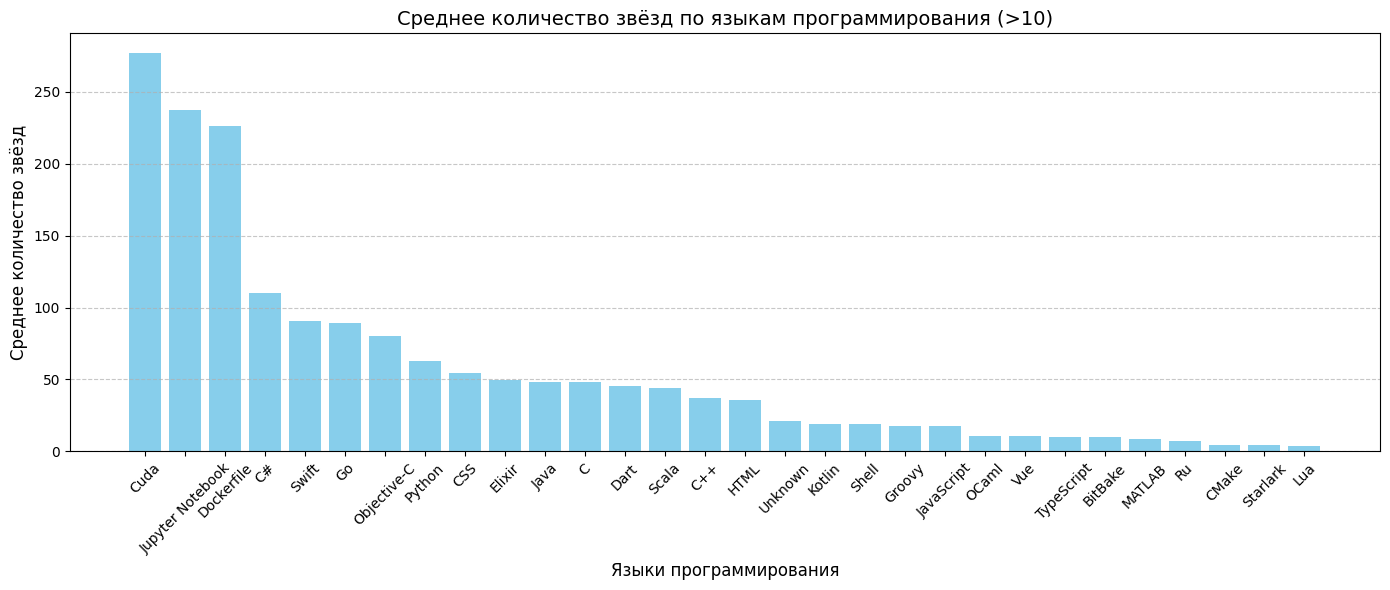

In [12]:
repo_languages = repo_df.copy()

def extract_main_language(language_str):
    if language_str and isinstance(language_str, str):
        match = re.match(r"\('?(.*?)[:s]", language_str)
        if match:
            return match.group(1)
    return "Unknown"

repo_languages["main_language"] = repo_languages["repo_languages"].apply(lambda x: extract_main_language(x))

language_counts = repo_languages["main_language"].value_counts()

popular_languages = language_counts[language_counts > 10].index

filtered_repo_languages = repo_languages[repo_languages["main_language"].isin(popular_languages)]
language_stars = filtered_repo_languages.groupby("main_language")["repo_stars"].mean().sort_values(ascending=False).reset_index()

top_languages = language_stars.head(30)

plt.figure(figsize=(14, 6))
plt.bar(top_languages["main_language"], top_languages["repo_stars"], color="skyblue")
plt.title("Среднее количество звёзд по языкам программирования (>10)", fontsize=14)
plt.xlabel("Языки программирования", fontsize=12)
plt.ylabel("Среднее количество звёзд", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Мария\AppData\Local\Temp\ipykernel_9892\3175757314.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(language_df['main_language'], rotation=45, ha='right')


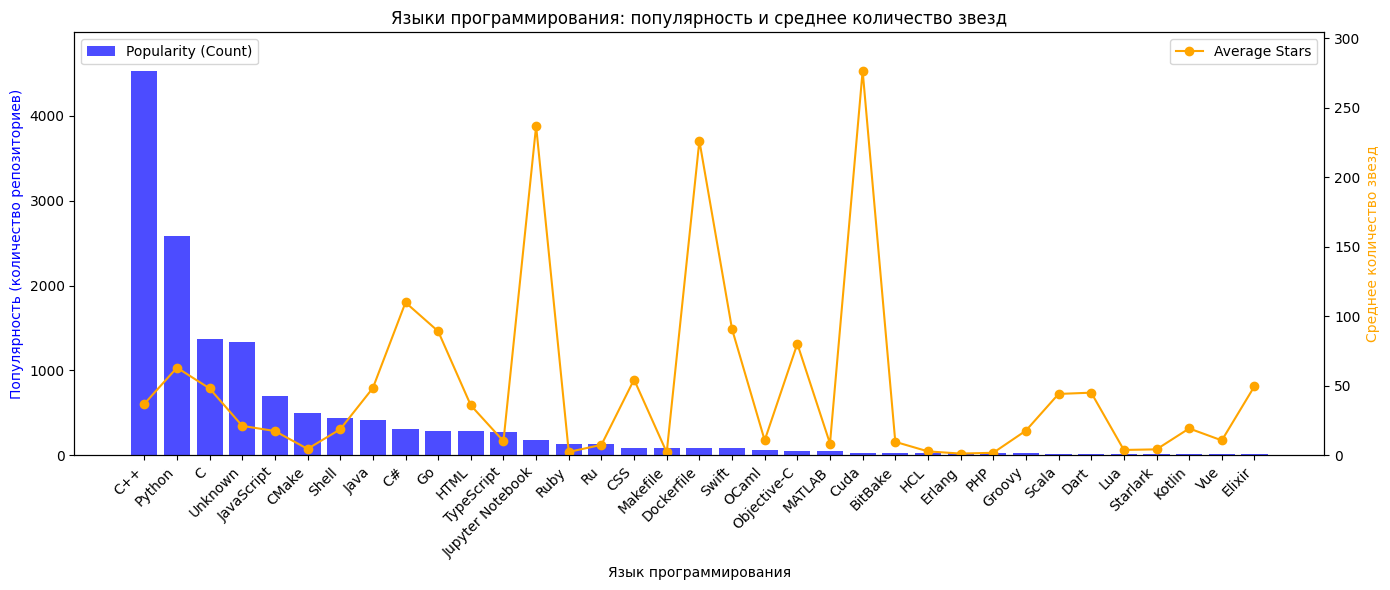

Корреляция между популярностью языка программирования и количеством звезд в репозитории с ним: -0.03


In [ ]:
language_count = repo_languages["main_language"].value_counts().sort_values(ascending=False).reset_index()
language_df = language_count.merge(language_stars[['main_language', 'repo_stars']], on = 'main_language')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(language_df['main_language'], language_df['count'], color='blue', label='Popularity (Count)', alpha=0.7)
ax2 = ax1.twinx()
ax2.plot(language_df['main_language'], language_df['repo_stars'], color='orange', marker='o', label='Average Stars')

ax1.set_xlabel('Язык программирования')
ax1.set_ylabel('Популярность (количество репозиториев)', color='blue')
ax2.set_ylabel('Среднее количество звезд', color='orange')
ax1.set_ylim(0, max(language_df['count']) * 1.1)
ax2.set_ylim(0, max(language_df['repo_stars']) * 1.1)
plt.title('Языки программирования: популярность и среднее количество звезд')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_xticklabels(language_df['main_language'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

correlation_language = language_df['count'].corr(language_df['repo_stars'])
print(f"Корреляция между популярностью языка программирования и количеством звезд в репозитории с ним: {correlation_language:.2f}")

### 2. Частые коммиты (или недавние коммиты) положительно влияют на популярность (по звёздам)

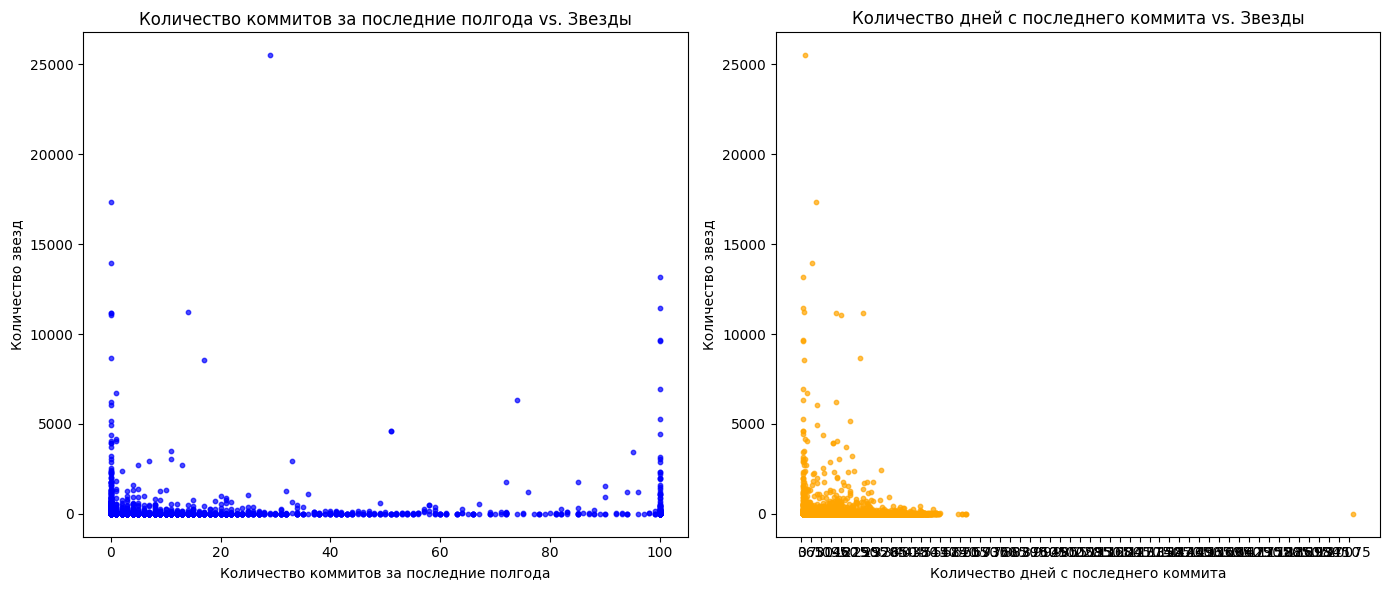

Корреляция между количеством коммитов за последние полгода и количеством звезд: 0.13
Корреляция между датой последнего коммита и количеством звезд: -0.06


In [38]:
repo_df[['repo_stars', 'repo_half_year_commits']].sort_values(by='repo_half_year_commits', ascending=False)

commits_repo = repo_df[['repo_stars', 'repo_half_year_commits', 'repo_last_commit_date']].sort_values(by='repo_half_year_commits', ascending=False)
commits_repo['repo_half_year_commits'] = pd.to_numeric(commits_repo['repo_half_year_commits'], errors='coerce')
commits_repo['repo_last_commit_date'] = pd.to_datetime(commits_repo['repo_last_commit_date'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

current_date = datetime.now()
def calculate_days_since_last_commit(date):
    if pd.isna(date): 
        return None  
    return (current_date - date).days

commits_repo['days_since_last_commit'] = commits_repo['repo_last_commit_date'].apply(calculate_days_since_last_commit)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(commits_repo['repo_half_year_commits'], commits_repo['repo_stars'], alpha=0.7, color='blue', s=10)
axs[0].set_title('Количество коммитов за последние полгода vs. Звезды')
axs[0].set_xlabel('Количество коммитов за последние полгода')
axs[0].set_ylabel('Количество звезд')

max_commits = commits_repo['repo_half_year_commits'].max()
xticks = np.arange(0, int(max_commits) + 10, 10)
plt.xticks(xticks)

axs[1].scatter(commits_repo['days_since_last_commit'], commits_repo['repo_stars'], alpha=0.7, color='orange', s=10)
axs[1].set_title('Количество дней с последнего коммита vs. Звезды')
axs[1].set_xlabel('Количество дней с последнего коммита')
axs[1].set_ylabel('Количество звезд')

max_days = commits_repo['days_since_last_commit'].max()
xticks = np.arange(0, int(max_days), 365)
plt.xticks(xticks)

plt.tight_layout()
plt.show()

correlation_commits1 = commits_repo['repo_half_year_commits'].corr(commits_repo['repo_stars'])
correlation_commits2 = commits_repo['days_since_last_commit'].corr(commits_repo['repo_stars'])

print(f"Корреляция между количеством коммитов за последние полгода и количеством звезд: {correlation_commits1:.2f}")
print(f"Корреляция между датой последнего коммита и количеством звезд: {correlation_commits2:.2f}")

### 3. Количество звёзд организации связано с количеством её репозиториев

Корреляция между количество звезд и количеством репозиториев: 0.13


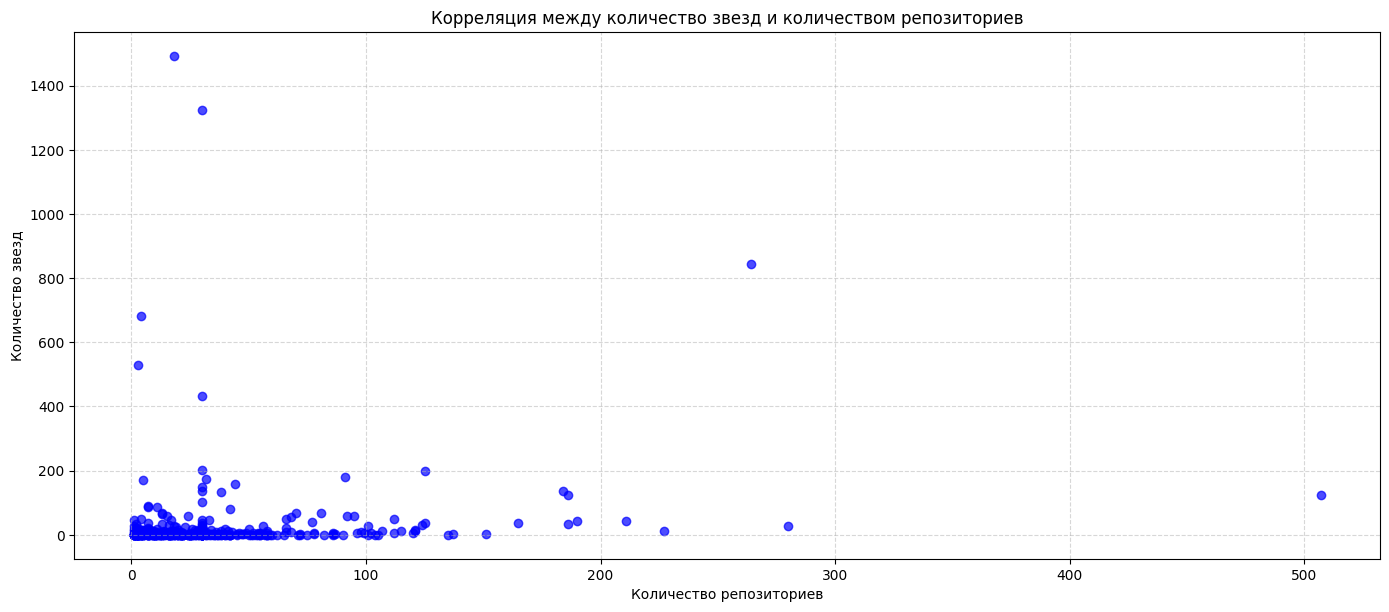

In [16]:
repos_count_df = repo_df.groupby('organization').agg(
    repo_count=('organization', 'size'),  
    total_stars=('repo_stars', 'mean')         
).sort_values(by='total_stars', ascending=False).reset_index()

correlation_repos = repos_count_df['repo_count'].corr(repos_count_df['total_stars'])

print(f"Корреляция между количество звезд и количеством репозиториев: {correlation_repos:.2f}")

plt.figure(figsize=(14, 6))
plt.scatter(repos_count_df['repo_count'], repos_count_df['total_stars'], alpha=0.7, color='blue')
plt.xlabel('Количество репозиториев')
plt.ylabel('Количество звезд')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.title('Корреляция между количество звезд и количеством репозиториев')

plt.show()

### 4. Репозитории с поддержкой ROS получают больше звёзд

In [17]:
ros_repo = repo_df[['repo_name', 'repo_topics', 'repo_stars']]

ros_repo.loc[:, 'has_ros_name'] = ros_repo['repo_name'].str.contains('ros', case=False, na=False)

ros_repo.loc[:, 'has_ros_topic'] = ros_repo['repo_topics'].apply(lambda x: 'ros' in x if isinstance(x, list) else False)

ros_repo.loc[:, 'has_ros_support'] = ros_repo['has_ros_name'] | ros_repo['has_ros_topic']
ros_repo = ros_repo.drop(['has_ros_name', 'has_ros_topic'], axis=1)

has_ros = ros_repo[ros_repo['has_ros_support'] == True]
no_ros = ros_repo[ros_repo['has_ros_support'] == False]

has_ros_avg_stars = has_ros['repo_stars'].mean()
no_ros_avg_stars = no_ros['repo_stars'].mean()

print(f"Среднее количество звезд у репозиториев с поддержкой ROS: {has_ros_avg_stars:.2f}")
print(f"Среднее количество звезд у репозиториев без поддержки ROS: {no_ros_avg_stars:.2f}")

Среднее количество звезд у репозиториев с поддержкой ROS: 9.38
Среднее количество звезд у репозиториев без поддержки ROS: 48.83


C:\Users\Мария\AppData\Local\Temp\ipykernel_9892\3216871289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ros_repo.loc[:, 'has_ros_name'] = ros_repo['repo_name'].str.contains('ros', case=False, na=False)
C:\Users\Мария\AppData\Local\Temp\ipykernel_9892\3216871289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ros_repo.loc[:, 'has_ros_topic'] = ros_repo['repo_topics'].apply(lambda x: 'ros' in x if isinstance(x, list) else False)
C:\Users\Мария\AppData\Local\Temp\ipykernel_9892\3216871289.py:7: Set

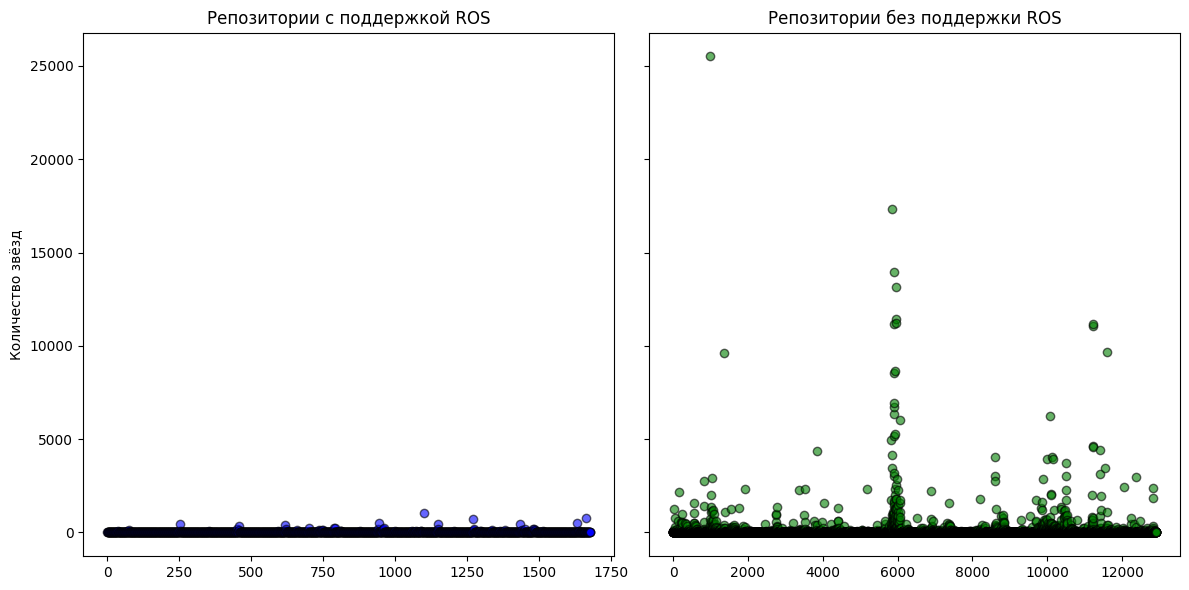

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].scatter(range(len(has_ros)), has_ros['repo_stars'], color='blue', alpha=0.6, edgecolor='black')
axes[0].set_title('Репозитории с поддержкой ROS')
axes[0].set_ylabel('Количество звёзд')

axes[1].scatter(range(len(no_ros)), no_ros['repo_stars'], color='green', alpha=0.6, edgecolor='black')
axes[1].set_title('Репозитории без поддержки ROS')

plt.tight_layout()
plt.show()

In [19]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(has_ros['repo_stars'], no_ros['repo_stars'], equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.2e}")

T-statistic: -8.78, P-value: 1.77e-18


In [20]:
ros_orgs = org_df[['organization', 'stars_count', 'ros_repos' ]]

ros_orgs.loc[:, 'ros_repos'] = ros_orgs['ros_repos'].apply(lambda x: eval(x) if isinstance(x, str) else x)

has_ros_orgs = ros_orgs[ros_orgs['ros_repos'].apply(lambda x: isinstance(x, list) and len(x) > 0)] 
no_ros_orgs = ros_orgs[ros_orgs['ros_repos'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

has_ros_org_avg_stars = has_ros_orgs['stars_count'].mean()
no_ros_org_avg_stars = no_ros_orgs['stars_count'].mean()

print(f"Среднее количество звезд у репозиториев с поддержкой ROS: {has_ros_org_avg_stars:.2f}")
print(f"Среднее количество звезд у репозиториев без поддержки ROS: {no_ros_org_avg_stars:.2f}")

Среднее количество звезд у репозиториев с поддержкой ROS: 350.58
Среднее количество звезд у репозиториев без поддержки ROS: 622.31


In [21]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(has_ros_orgs['stars_count'], no_ros_orgs['stars_count'], equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.2e}")

T-statistic: -1.23, P-value: 2.21e-01


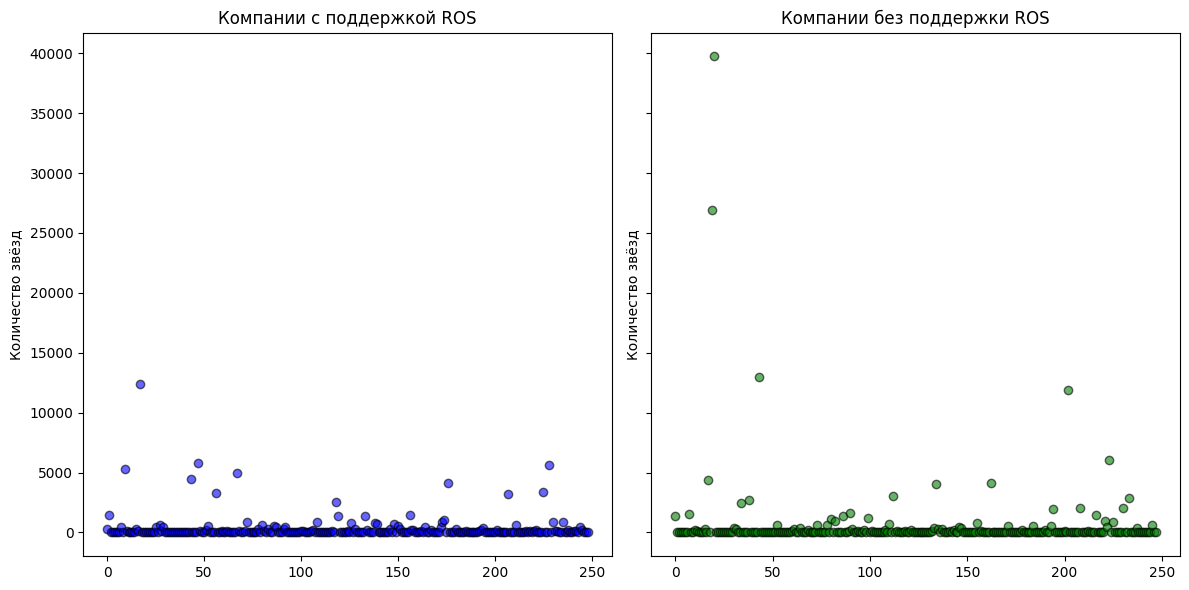

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].scatter(range(len(has_ros_orgs)), has_ros_orgs['stars_count'], color='blue', alpha=0.6, edgecolor='black')
axes[0].set_title('Компании с поддержкой ROS')
axes[0].set_ylabel('Количество звёзд')

axes[1].scatter(range(len(no_ros_orgs)), no_ros_orgs['stars_count'], color='green', alpha=0.6, edgecolor='black')
axes[1].set_title('Компании без поддержки ROS')
axes[1].set_ylabel('Количество звёзд')

plt.tight_layout()
plt.show()

### 5. Компании с более подробными (длинными) описаниями имеют больше звёзд в их репозиториях

In [24]:
with open("by_repo_results.csv", "r", encoding='utf-8') as f:
  csvreader = csv.reader(f, delimiter=";")
  headers = next(csvreader)
  data = []
  for row in csvreader:
    if row[0] != " ":
      company_name = row[0]
      data.append(row)
    else:
      # if company_name in allowed_orgs:
        # print(row)
        row[0] = company_name
        data.append(row)

repo2_df = pd.DataFrame(data=data, columns=headers)
repo2_df['repo_stars'] = pd.to_numeric(repo2_df['repo_stars'], errors='coerce')
repo2_df['repo_stars'] = repo2_df['repo_stars'].fillna(0)

description_repo = repo2_df[['organization', 'description', 'repo_stars']].drop_duplicates()
description_repo['length'] = description_repo['description'].apply(lambda x: len(str(x).split()))

description_repo = description_repo.groupby('organization').agg(
    length=('length', 'max'),
    total_stars=('repo_stars', 'sum')
).sort_values(by='total_stars', ascending=False).reset_index().tail(300)

Корреляция между длиной описания и количеством звёзд: 0.03


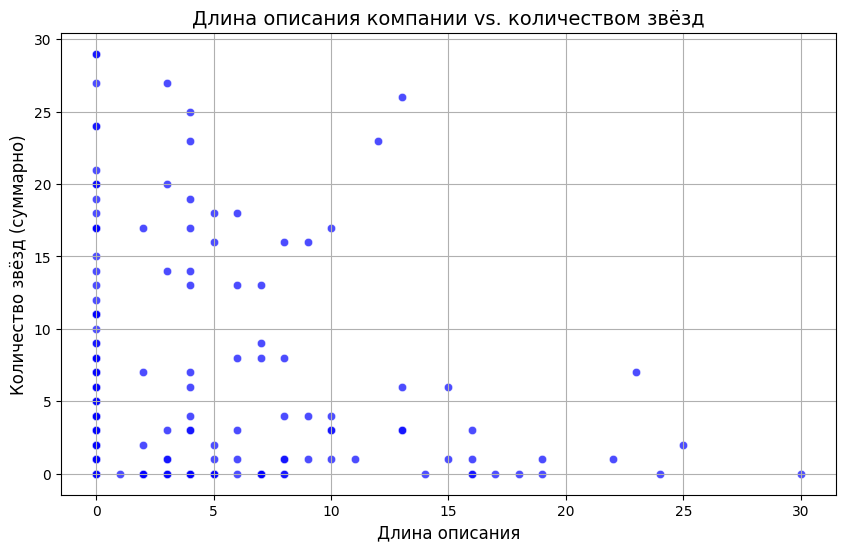

In [25]:
correlation_desk = description_repo['length'].corr(description_repo['total_stars'])
print(f"Корреляция между длиной описания и количеством звёзд: {correlation_desk:.2f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=description_repo, x='length', y='total_stars', alpha=0.7, color='blue')

plt.title("Длина описания компании vs. количеством звёзд", fontsize=14)
plt.xlabel("Длина описания", fontsize=12)
plt.ylabel("Количество звёзд (суммарно)", fontsize=12)
plt.grid(True)
plt.show()

### 6. Наличие тем в репозитории положительно влияет на его популярность

In [26]:
repo_topics = repo_df[['organization', 'repo_stars','repo_topics']]

repo_topics.loc[:, 'repo_topics'] = repo_topics['repo_topics'].apply(lambda x: eval(x) if isinstance(x, str) else x)

has_topics_repos = repo_topics[repo_topics['repo_topics'].apply(lambda x: isinstance(x, list) and len(x) > 0)].sort_values(by='repo_stars').head(900)
no_topics_repos = repo_topics[repo_topics['repo_topics'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

has_topics_repos_avg_stars = has_topics_repos['repo_stars'].mean()
no_topics_repos_avg_stars = no_topics_repos['repo_stars'].mean()

print(f"Среднее количество звезд у репозиториев с темами: {has_topics_repos_avg_stars:.2f}")
print(f"Среднее количество звезд у репозиториев без тем: {no_topics_repos_avg_stars:.2f}")

print(has_topics_repos['repo_stars'].sort_values())

Среднее количество звезд у репозиториев с темами: 2.87
Среднее количество звезд у репозиториев без тем: 22.50
14530     0
164       0
14529     0
512       0
10402     0
         ..
11074    10
5738     10
11227    10
9937     10
7094     10
Name: repo_stars, Length: 900, dtype: int32


In [27]:
t_stat, p_value = stats.ttest_ind(has_topics_repos['repo_stars'], no_topics_repos['repo_stars'], nan_policy='omit')

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

t-statistic: -2.72
p-value: 0.0066


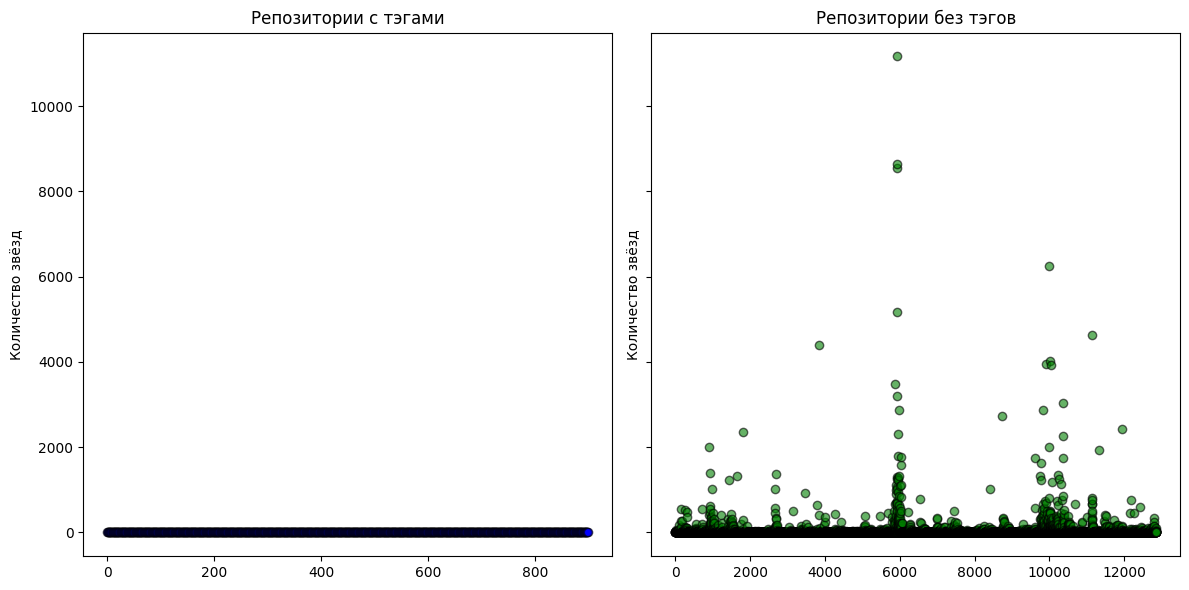

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].scatter(range(len(has_topics_repos)), has_topics_repos['repo_stars'], color='blue', alpha=0.6, edgecolor='black')
axes[0].set_title('Репозитории с тэгами')
axes[0].set_ylabel('Количество звёзд')

axes[1].scatter(range(len(no_topics_repos)), no_topics_repos['repo_stars'], color='green', alpha=0.6, edgecolor='black')
axes[1].set_title('Репозитории без тэгов')
axes[1].set_ylabel('Количество звёзд')

plt.tight_layout()
plt.show()